In [ ]:
# %pip install scikit-learn
# %pip install tensorflow
# %pip install seaborn matplotlib pandas

Found 3447 images belonging to 2 classes.
Found 861 images belonging to 2 classes.
Found 4308 images belonging to 2 classes.
Found 3032 images belonging to 2 classes.
Found 1020 images belonging to 2 classes.
Found 1019 images belonging to 2 classes.
Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6518 - loss: 0.6407 - val_accuracy: 0.6559 - val_loss: 0.6077
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 841ms/step - accuracy: 0.5937 - loss: 0.6399 - val_accuracy: 0.7245 - val_loss: 0.5487
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 842ms/step - accuracy: 0.7198 - loss: 0.5285 - val_accuracy: 0.7961 - val_loss: 0.4845
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 847ms/step - accuracy: 0.7268 - loss: 0.5084 - val_accuracy: 0.8039 - val_loss: 0.4565
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 846ms/step - accuracy: 0.8188 - loss: 0.4601 - val_accuracy: 0.8039 - val_loss: 0.4310
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 844ms/step - accuracy: 0.7849 - loss: 0.4756 - val_accuracy: 0.8098 - 

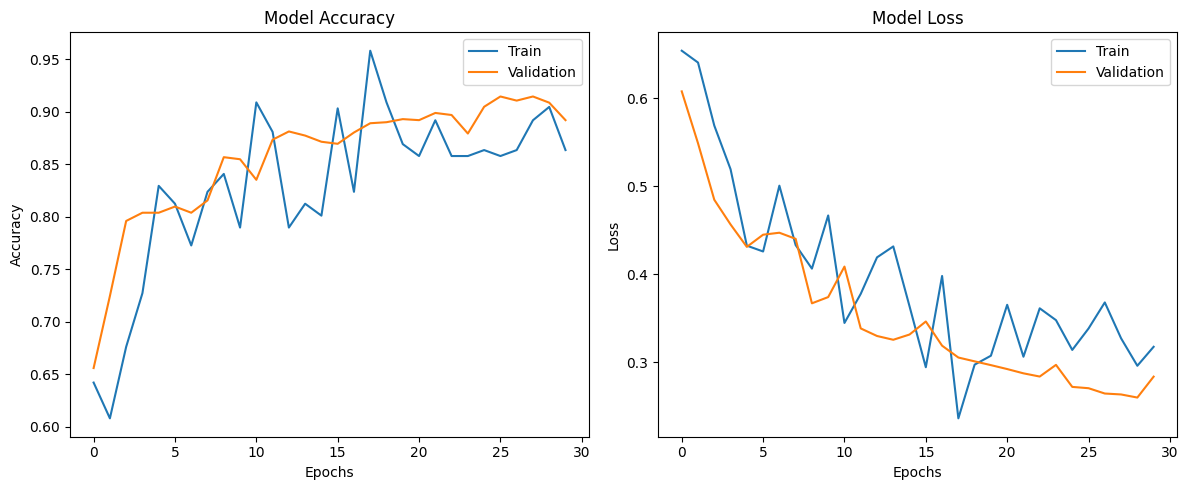

2024-09-19 15:05:50.433015: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Testing Accuracy:  0.9127
Training complete!


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

import warnings
warnings.filterwarnings('ignore')

clear_session()  # This frees the GPU memory, peventing training deadlock

# Function to create directories
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
setz = ['metal','glass', 'trash', 'cardboard', 'paper', 'plastic']

for setClass in [setz[2]]: #setz:
    clear_session()
    global classez
    classez = [setClass, 'other']
    # data path
    global dataset_path
    dataset_path = f'/app/data/Datasets/augmented_{classez[0]}_and_{classez[1]}'  # <- docker file path      # "G:\My Drive\Datasets\ "
    

    tar = (224, 224)
    batch = 16 # 16
    #Split the dataset
    # Create an ImageDataGenerator for each subset
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% for validation

    # Training data generator
    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=tar,
        batch_size=batch,
        class_mode='binary',
        subset='training')  # Set as training data

    # Validation data generator
    validation_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=tar,
        batch_size=batch,
        class_mode='binary',
        subset='validation')  # Set as validation data

    # Create a separate ImageDataGenerator for test data
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Test data generator
    test_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=tar,
        batch_size=batch,
        class_mode='binary')  # No subset for testing
    
   

    # Paths to save splits
    base_dir = f'/app/data/Datasets/augmented_{classez[0]}_and_{classez[1]}-split'  # "G:\My Drive\Datasets\Trashnet-resized-split"
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    create_dir(base_dir)
    create_dir(train_dir)
    create_dir(val_dir)
    create_dir(test_dir)

    for class_name in classez: #, 'cardboard', 'metal', 'paper', 'plastic', 'trash']:
        # Create class directories
        create_dir(os.path.join(train_dir, class_name))
        create_dir(os.path.join(val_dir, class_name))
        create_dir(os.path.join(test_dir, class_name))

        # List all files in the class directory
        class_files = os.listdir(os.path.join(dataset_path, class_name))
        train_files, test_files = train_test_split(class_files, test_size=0.2, random_state=42)  # 20% for testing
        train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42)  # 20% of remaining for validation (0.25 * 0.8 = 0.2)

        # Copy files to respective directories
        for file in train_files:
            shutil.copy(os.path.join(dataset_path, class_name, file), os.path.join(train_dir, class_name, file))

        for file in val_files:
            shutil.copy(os.path.join(dataset_path, class_name, file), os.path.join(val_dir, class_name, file))

        for file in test_files:
            shutil.copy(os.path.join(dataset_path, class_name, file), os.path.join(test_dir, class_name, file))
        
    train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=tar,
    batch_size=batch,
    class_mode='binary'
    # ,color_mode='grayscale'
    )

    validation_generator = datagen.flow_from_directory(
        val_dir,
        target_size=tar,
        batch_size=batch,
        class_mode='binary'
        # ,color_mode='grayscale'
        )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=tar,
        batch_size=batch,
        class_mode='binary'
        # ,color_mode='grayscale'
        )

    img_shape = (224,224,3)
    img_size = tar
    batch_size = batch #16 #32
    num_classes = 2
    log_file = '/app/data/code/accuracy_log7.csv'

    # DenseNet201 # MobileNetV3 # EfficientNetB0
    base_model = tf.keras.applications.DenseNet201(input_shape=img_shape,
                                                include_top=False,
                                                weights='imagenet')

    model_name = base_model.name #'EfficientNetB0' # 'DenseNet201' # 'MobileNetV2'
    # print(model_name)

    base_model.trainable = False
    for layer in base_model.layers[-6:]:
        layer.trainable = True
        
    class AccuracyLogger(Callback):
        def __init__(self,   log_file, model_name, img_shape, batch_size, num_classes):
            super().__init__()
            self.log_file = log_file
            self.model_name = model_name
            self.img_shape = img_shape
            self.batch_size = batch_size
            self.num_classes = num_classes
            
            # self.summary = summary

            # Write model and dataset information at the beginning of the log file
            with open(self.log_file, 'a') as f:
                f.write(f"\nModel: {self.model_name}\n")
                # f.write(f"Model summary:{self.summary}\n")
                f.write(f"Image shape: {self.img_shape}\n")
                f.write(f"Batch size: {self.batch_size}\n")
                f.write(f"Dataset: {dataset_path}\n")
                f.write(f"Number of classes: {self.num_classes}\n\n")
                f.write('Epoch,Accuracy,Validation Accuracy, Loss, Validation Loss\n')
                f.flush()

        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            accuracy = logs.get('accuracy')
            val_accuracy = logs.get('val_accuracy')
            loss = logs.get('loss')
            val_loss = logs.get('val_loss')

            # Write the epoch, accuracy, and validation accuracy to the log file
            with open(self.log_file, 'a') as f:
                f.write(f"{epoch + 1},{accuracy},{val_accuracy},{loss},{val_loss}\n")
                f.flush()

    model = tf.keras.Sequential([base_model,
                                #  tf.keras.layers.Flatten(),
                                tf.keras.layers.GlobalAveragePooling2D(),
                                #  tf.keras.layers.Dense(batch, activation="relu"),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(1, activation="sigmoid")
                                #  tf.keras.layers.Dense(2, activation="softmax")
                                ])

    lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                    patience=2, 
                                    factor=0.3, #0.5,
                                    verbose=1, 
                                    min_lr=0.01) #0.01)
    model.compile(optimizer = 'sgd',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    #Train for 10 epochs
    steps_per_epoch=int(len(train_generator)/batch_size)
    validation_steps = validation_generator.samples // validation_generator.batch_size

    # model.summary()
    # summary_buffer = io.StringIO()

    # # Redirect the stdout to the buffer and call model.summary()
    # with redirect_stdout(summary_buffer):
    #     model.summary()

    # # Get the summary as a string
    # summary = summary_buffer.getvalue()

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        callbacks=[AccuracyLogger(  log_file, model_name, img_shape, batch_size, num_classes),
                    EarlyStopping(patience=5)],
        epochs=30,
        verbose=1
    )

    def plot_graphs(history, batch_size):
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

        # Plot accuracy
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].set_title("Model Accuracy")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend(['Train', 'Validation'])

        # Plot loss
        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title("Model Loss")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Loss")
        axs[1].legend(['Train', 'Validation'])

        plt.tight_layout()  # Adjust layout to make sure plots don't overlap

        # Ensure the save directory exists
        save_dir = '/app/data/graphs/'
        os.makedirs(save_dir, exist_ok=True)

        # Create the filename using the dataset path and batch size
        dataset_name = os.path.basename(dataset_path[29:])  # filter out '/app/data/Datasets/' 
        filename = f"{dataset_name}_30epoch_batch{batch_size}_{model_name}.png"

        # Save the figure
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path)
        print(f"Graph saved at: {save_path}")

        plt.show()

    # plot
    plot_graphs(history, batch)

    loss, accuracy = model.evaluate(test_generator, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    with open(log_file, 'a') as f:
        f.write(f"Testing Accuracy:  {accuracy:.4f}\n")
        f.flush()

    # save model
    model.save("tf_model.keras")

print("Training complete!")
